# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


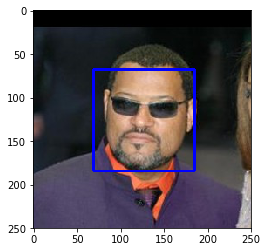

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

 - 99% of the images in human_files were detected as human faces.
 - 11% of the images in dog_files were detected as human faces too.
 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
true_human=0
false_human=0
for img in human_files_short:
    if face_detector(img):
        true_human+=1
print(true_human, '% of the human faces are classified as human faces.')

for img in dog_files_short:
    if face_detector(img):
        false_human+=1
print(false_human, '% of the dog images are classified as human faces.' )

99 % of the human faces are classified as human faces.
11 % of the dog images are classified as human faces.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

I think that this is a reasonable expectation. It is not too hard to make sure images contain a clear view of a human face, most pictures taken of people would automatically qualify. It is also very easy to take pictures and people (in general) enjoy taking pictures and so probably would not mind taking one to use the app. It would also make the experience even more streamlined and easy if the app also included an option to access the devices camera to take a picture.

Most people who use the app to determine what dog breed they or someone else resemble most would inherently be interested in the persons face.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

 - 1% of human files have a detected dog
 - 100% of dog files have a detected dog

In [24]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
true_dog=0
false_dog=0
for img in human_files_short:
    if dog_detector(img):
        false_dog+=1
print(false_dog, '% of the human images are classified as dogs.')

for img in dog_files_short:
    if dog_detector(img):
        true_dog+=1
print(true_dog, '% of the dog images are classified as dogs.' )

1 % of the human images are classified as dogs.
100 % of the dog images are classified as dogs.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:05<00:00, 147.17it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

The steps that I took to get to get my final architecture were iterative and a balancing act between adding the number of layers that I wanted to experiment with and the amount of time taken to train that network on a CPU since I had trouble setting up my AWS account. 

My plan was to start with an architecture of 4 convulutional layers and 3 dense layers thereafter. I wanted to have a failry large number of filters in the layers to try and capture as many patterns as possible since to discriminate between different dog breeds, general features would not be enough. I also wanted to experiment with gradually smaller filter sizes as I moved through convolutional layers to capture different sized patterns in the hope that more subtle features would be detected. 

In the end, I defined several models and from the resulting number of parameters, iteratively worked out whether each model was practical to run and reduced the number of parameters if it wasn't. I ended up trying two models which were fast enough to run on my CPU. Both had 2 convolutional layers with max pooling and dropout between layers. The first had two dense layers thereafter and fewer filters in the convolutional layers and the final one which I ended up using has only a final softmax dense layer but more filters in each convolutional layer. The first had an accuracy of aroun 9% and this final one did slightly better with around 10.3% accuracy.

In the first convolutional layer, I had 100 filters to identify as many different low level patterns, textures and colours as possible. I also wanted a fairly large number so that there were a number of inputs into the second layer to create as different complex filters as possible. In the second layer, I added a lot more filters (300) since this was my last and so most complex layer in terms of pattern complexity, I wanted to identify as many complex patterns as possible for differentiation between dog breeds. Both layers had dropout applied to reduce overfitting and max pooling layers after them to reduce the number of parameters. The final dense layer was just a softmax prediction layer giving a probability of belonging to each of the 13 breeds.

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=100, kernel_size=5, padding='same',activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=5))
model.add(Dropout(0.4))

model.add(Conv2D(filters=300, kernel_size=5, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 100)     7600      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 44, 100)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 44, 44, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 300)       750300    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 300)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 300)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 19200)             0         
__________

### Compile the Model

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 1154s - loss: 4.9308 - acc: 0.0102 - val_loss: 4.8396 - val_acc: 0.0108
Epoch 2/10


4080/6680 [=================>............] - ETA: 1125s - loss: 4.7692 - acc: 0.05 - ETA: 1144s - loss: 4.8868 - acc: 0.02 - ETA: 1135s - loss: 4.8734 - acc: 0.01 - ETA: 1127s - loss: 4.8563 - acc: 0.01 - ETA: 1124s - loss: 4.8553 - acc: 0.01 - ETA: 1123s - loss: 4.8552 - acc: 0.00 - ETA: 1116s - loss: 4.8448 - acc: 0.01 - ETA: 1113s - loss: 4.8325 - acc: 0.01 - ETA: 1111s - loss: 4.8454 - acc: 0.01 - ETA: 1107s - loss: 4.8347 - acc: 0.02 - ETA: 1103s - loss: 4.8464 - acc: 0.01 - ETA: 1100s - loss: 4.8565 - acc: 0.02 - ETA: 1097s - loss: 4.8612 - acc: 0.01 - ETA: 1095s - loss: 4.8605 - acc: 0.01 - ETA: 1092s - loss: 4.8649 - acc: 0.01 - ETA: 1088s - loss: 4.8593 - acc: 0.01 - ETA: 1084s - loss: 4.8530 - acc: 0.01 - ETA: 1081s - loss: 4.8548 - acc: 0.01 - ETA: 1077s - loss: 4.8576 - acc: 0.01 - ETA: 1073s - loss: 4.8568 - acc: 0.01 - ETA: 1069s - loss: 4.8560 - acc: 0.01 - ETA: 1066s - loss: 4.8552 - acc: 0.01 - ETA: 1063s - loss: 4.8528 - acc: 0.01 - ETA: 1060s - loss: 4.8471 - acc: 0.

6680/6680 [==============================] - 2868s - loss: 4.7058 - acc: 0.0382 - val_loss: 4.5731 - val_acc: 0.0551
Epoch 3/10
6680/6680 [==============================] - 1235s - loss: 4.3587 - acc: 0.0726 - val_loss: 4.3827 - val_acc: 0.0754
Epoch 4/10


4080/6680 [=================>............] - ETA: 1229s - loss: 3.8373 - acc: 0.15 - ETA: 1202s - loss: 4.1059 - acc: 0.10 - ETA: 1185s - loss: 4.3002 - acc: 0.06 - ETA: 1173s - loss: 4.2208 - acc: 0.08 - ETA: 1165s - loss: 4.1788 - acc: 0.08 - ETA: 1158s - loss: 4.1728 - acc: 0.10 - ETA: 1151s - loss: 4.1658 - acc: 0.10 - ETA: 1147s - loss: 4.1592 - acc: 0.10 - ETA: 1142s - loss: 4.1049 - acc: 0.11 - ETA: 1139s - loss: 4.1153 - acc: 0.11 - ETA: 1138s - loss: 4.1304 - acc: 0.10 - ETA: 1134s - loss: 4.1505 - acc: 0.10 - ETA: 1129s - loss: 4.1354 - acc: 0.11 - ETA: 1125s - loss: 4.1085 - acc: 0.12 - ETA: 1122s - loss: 4.1491 - acc: 0.12 - ETA: 1118s - loss: 4.1497 - acc: 0.12 - ETA: 1114s - loss: 4.1483 - acc: 0.12 - ETA: 1111s - loss: 4.1212 - acc: 0.14 - ETA: 1107s - loss: 4.1052 - acc: 0.14 - ETA: 1104s - loss: 4.0898 - acc: 0.14 - ETA: 1100s - loss: 4.0793 - acc: 0.13 - ETA: 1096s - loss: 4.0784 - acc: 0.13 - ETA: 1093s - loss: 4.0607 - acc: 0.13 - ETA: 1090s - loss: 4.0683 - acc: 0.

6680/6680 [==============================] - 3911s - loss: 4.0454 - acc: 0.1186 - val_loss: 4.2723 - val_acc: 0.0910
Epoch 5/10
6680/6680 [==============================] - 1238s - loss: 3.7579 - acc: 0.1570 - val_loss: 4.2391 - val_acc: 0.0790
Epoch 6/10


4080/6680 [=================>............] - ETA: 1176s - loss: 3.5172 - acc: 0.30 - ETA: 1178s - loss: 3.4598 - acc: 0.30 - ETA: 1174s - loss: 3.6048 - acc: 0.21 - ETA: 1170s - loss: 3.4493 - acc: 0.22 - ETA: 1165s - loss: 3.4237 - acc: 0.23 - ETA: 1161s - loss: 3.4999 - acc: 0.22 - ETA: 1158s - loss: 3.5389 - acc: 0.22 - ETA: 1154s - loss: 3.5611 - acc: 0.19 - ETA: 1149s - loss: 3.5679 - acc: 0.20 - ETA: 1146s - loss: 3.5577 - acc: 0.20 - ETA: 1144s - loss: 3.5778 - acc: 0.18 - ETA: 1143s - loss: 3.5829 - acc: 0.17 - ETA: 1138s - loss: 3.5481 - acc: 0.17 - ETA: 1135s - loss: 3.5181 - acc: 0.18 - ETA: 1130s - loss: 3.5301 - acc: 0.18 - ETA: 1126s - loss: 3.4905 - acc: 0.19 - ETA: 1122s - loss: 3.5203 - acc: 0.19 - ETA: 1118s - loss: 3.5230 - acc: 0.19 - ETA: 1115s - loss: 3.5228 - acc: 0.19 - ETA: 1111s - loss: 3.5498 - acc: 0.18 - ETA: 1107s - loss: 3.5564 - acc: 0.18 - ETA: 1102s - loss: 3.5659 - acc: 0.18 - ETA: 1098s - loss: 3.5713 - acc: 0.18 - ETA: 1095s - loss: 3.5695 - acc: 0.

6680/6680 [==============================] - 1195s - loss: 3.5360 - acc: 0.2012 - val_loss: 4.1715 - val_acc: 0.1138
Epoch 7/10
6680/6680 [==============================] - 1193s - loss: 3.2941 - acc: 0.2412 - val_loss: 4.1878 - val_acc: 0.1018
Epoch 8/10


4080/6680 [=================>............] - ETA: 1135s - loss: 2.9123 - acc: 0.25 - ETA: 1133s - loss: 2.6291 - acc: 0.32 - ETA: 1127s - loss: 2.7458 - acc: 0.30 - ETA: 1131s - loss: 2.7512 - acc: 0.30 - ETA: 1128s - loss: 2.8903 - acc: 0.29 - ETA: 1123s - loss: 2.9884 - acc: 0.26 - ETA: 1118s - loss: 2.9479 - acc: 0.27 - ETA: 1113s - loss: 2.9233 - acc: 0.28 - ETA: 1111s - loss: 2.9575 - acc: 0.27 - ETA: 1107s - loss: 2.9139 - acc: 0.28 - ETA: 1104s - loss: 3.0046 - acc: 0.26 - ETA: 1101s - loss: 2.9802 - acc: 0.27 - ETA: 1098s - loss: 2.9763 - acc: 0.27 - ETA: 1094s - loss: 3.1006 - acc: 0.25 - ETA: 1092s - loss: 3.1129 - acc: 0.25 - ETA: 1089s - loss: 3.0999 - acc: 0.25 - ETA: 1085s - loss: 3.0952 - acc: 0.26 - ETA: 1082s - loss: 3.0925 - acc: 0.25 - ETA: 1078s - loss: 3.0907 - acc: 0.25 - ETA: 1075s - loss: 3.1556 - acc: 0.25 - ETA: 1071s - loss: 3.1553 - acc: 0.25 - ETA: 1067s - loss: 3.1437 - acc: 0.26 - ETA: 1064s - loss: 3.1554 - acc: 0.25 - ETA: 1060s - loss: 3.1522 - acc: 0.

6680/6680 [==============================] - 1189s - loss: 3.1031 - acc: 0.2711 - val_loss: 4.2256 - val_acc: 0.1090
Epoch 9/10
6680/6680 [==============================] - 1189s - loss: 2.9343 - acc: 0.3108 - val_loss: 4.2069 - val_acc: 0.1066
Epoch 10/10


4080/6680 [=================>............] - ETA: 1124s - loss: 2.8774 - acc: 0.40 - ETA: 1131s - loss: 2.7289 - acc: 0.42 - ETA: 1130s - loss: 2.8101 - acc: 0.35 - ETA: 1126s - loss: 2.5903 - acc: 0.41 - ETA: 1123s - loss: 2.5090 - acc: 0.44 - ETA: 1115s - loss: 2.5359 - acc: 0.40 - ETA: 1115s - loss: 2.4636 - acc: 0.40 - ETA: 1115s - loss: 2.4850 - acc: 0.41 - ETA: 1111s - loss: 2.5115 - acc: 0.42 - ETA: 1106s - loss: 2.5010 - acc: 0.42 - ETA: 1102s - loss: 2.5062 - acc: 0.41 - ETA: 1099s - loss: 2.4876 - acc: 0.42 - ETA: 1096s - loss: 2.4509 - acc: 0.42 - ETA: 1094s - loss: 2.4428 - acc: 0.42 - ETA: 1090s - loss: 2.4458 - acc: 0.42 - ETA: 1088s - loss: 2.4962 - acc: 0.40 - ETA: 1084s - loss: 2.5074 - acc: 0.40 - ETA: 1081s - loss: 2.5296 - acc: 0.39 - ETA: 1077s - loss: 2.5287 - acc: 0.39 - ETA: 1073s - loss: 2.5358 - acc: 0.38 - ETA: 1070s - loss: 2.5502 - acc: 0.38 - ETA: 1067s - loss: 2.5688 - acc: 0.38 - ETA: 1064s - loss: 2.5955 - acc: 0.37 - ETA: 1060s - loss: 2.6073 - acc: 0.

6680/6680 [==============================] - 1208s - loss: 2.7963 - acc: 0.3335 - val_loss: 4.2926 - val_acc: 0.1090


### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.2871%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [30]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [31]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [41]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 13.1085 - acc: 0.0856 - val_loss: 11.5323 - val_acc: 0.1725
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.7690 - acc: 0.2340 - val_loss: 10.5586 - val_acc: 0.2467
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.1666 - acc: 0.3024 - val_loss: 10.3119 - val_acc: 0.2778
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.9400 - acc: 0.3347 - val_loss: 10.2207 - val_acc: 0.2874
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.8324 - acc: 0.3557 - val_loss: 10.1652 - val_acc: 0.3102
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.7085 - acc: 0.3656 - val_loss: 9.9828 - val_acc: 0.3078
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.5408 - acc: 0.3847 - val_loss: 9.9130 - val_acc: 0.3246
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 9.4

6680/6680 [==============================] - 1s - loss: 9.1353 - acc: 0.4175 - val_loss: 9.6253 - val_acc: 0.3425
Epoch 14/20
6680/6680 [==============================] - 1s - loss: 9.0275 - acc: 0.4284 - val_loss: 9.6844 - val_acc: 0.3293
Epoch 15/20
6680/6680 [==============================] - 1s - loss: 8.9453 - acc: 0.4320 - val_loss: 9.4910 - val_acc: 0.3533
Epoch 16/20
6680/6680 [==============================] - 1s - loss: 8.7972 - acc: 0.4404 - val_loss: 9.3897 - val_acc: 0.3497
Epoch 17/20
6680/6680 [==============================] - 1s - loss: 8.7173 - acc: 0.4473 - val_loss: 9.3941 - val_acc: 0.3485
Epoch 18/20
6680/6680 [==============================] - 1s - loss: 8.5272 - acc: 0.4563 - val_loss: 9.1990 - val_acc: 0.3641
Epoch 19/20
6680/6680 [==============================] - 1s - loss: 8.4783 - acc: 0.4641 - val_loss: 9.1957 - val_acc: 0.3593
Epoch 20/20
6680/6680 [==============================] - 1s - loss: 8.4520 - acc: 0.4686 - val_loss: 9.1255 - val_acc: 0.3677


### Load the Model with the Best Validation Loss

In [42]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [43]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 34.9282%


### Predict Dog Breed with the Model

In [44]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [12]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Again, due to computational time constraints, I did not experiment with adding any large convolutional layers to the original InceptionV3 architecture. I also experimented with the ResNet networks bottleneck features but found the Inception bottle neck features worked better.

I found that adding extra convolutional layers to the predefined architecture and especially layers with not too many filters actually caused the model to perform much worse than if I had added nothing more than a dense softmax prediction layer to the existing model. For this reason, I opted not to add any extra convolutional layers at all. Similarly adding too many extra dense layers had an advese effect on accuracy when compared to the basline line of just adding a final prediction layer. 

I settled eventually on adding just one large dense layer after global average pooling of the convolutional layers instead of just flattening the results. I chose a large dense layer (500 nodes) since I wanted it to have more nodes than the prediction step in the hopes of capturing as many unique features from the convolutional layers as possible instead of wasting all the pattern recognition from the convolutional layer by conglomerating them into too few nodes. I used dropout to prevent overfitting to this dense layer and a sigmoid activation function since this gave me the best results.

Finally, I added the same dense sofmax prediction layer with 133 nodes.

I think that this architecture is suitable since the Inception model trained on the ImageNet data already has a large number of patterns learned (including dog breeds) as so the data it was trained on is quite similar to our data except that it also had many other additional classes. Adding just one softmax layer at then end to get the model to focus only on the dog breeds themselves is therefore quite sufficient for predicting dog breeds and indeed achieves around 80% accuracy. Since our training data set is fairly large and is somewhat similar to the ImageNet data set that the Inception architecture was trained on, it makes sense to keep the Incpetion models learned weights and remove just its final dense layers which are replaced with our own. Our own added layers are then trained with backpropogation to optimize and fine-tune the model for our specific data.


In [13]:
### TODO: Define your architecture.

InceptionV3_model = Sequential()

InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))

InceptionV3_model.add(Dense(500, activation='sigmoid', ))
InceptionV3_model.add(Dropout(0.4))

InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               66633     
Total params: 1,091,133
Trainable params: 1,091,133
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [60]:
### TODO: Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [61]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 8s - loss: 1.6744 - acc: 0.6310 - val_loss: 0.6087 - val_acc: 0.8347
Epoch 2/20
6680/6680 [==============================] - 7s - loss: 0.6107 - acc: 0.8135 - val_loss: 0.5362 - val_acc: 0.8180
Epoch 3/20


6680/6680 [==============================] - 7s - loss: 0.4733 - acc: 0.8454 - val_loss: 0.5071 - val_acc: 0.8467
Epoch 4/20
6680/6680 [==============================] - 7s - loss: 0.3956 - acc: 0.8659 - val_loss: 0.5280 - val_acc: 0.8347
Epoch 5/20


6680/6680 [==============================] - 7s - loss: 0.3480 - acc: 0.8861 - val_loss: 0.4858 - val_acc: 0.8503
Epoch 6/20
6680/6680 [==============================] - 7s - loss: 0.2939 - acc: 0.9019 - val_loss: 0.5156 - val_acc: 0.8551
Epoch 7/20


6680/6680 [==============================] - 7s - loss: 0.2582 - acc: 0.9118 - val_loss: 0.5152 - val_acc: 0.8455
Epoch 8/20
6680/6680 [==============================] - 7s - loss: 0.2292 - acc: 0.9228 - val_loss: 0.5150 - val_acc: 0.8443
Epoch 9/20


6680/6680 [==============================] - 7s - loss: 0.2089 - acc: 0.9254 - val_loss: 0.5410 - val_acc: 0.8539
Epoch 10/20
6680/6680 [==============================] - 7s - loss: 0.1781 - acc: 0.9397 - val_loss: 0.5693 - val_acc: 0.8551
Epoch 11/20


6680/6680 [==============================] - 7s - loss: 0.1582 - acc: 0.9448 - val_loss: 0.6229 - val_acc: 0.8383
Epoch 12/20
6680/6680 [==============================] - 7s - loss: 0.1498 - acc: 0.9485 - val_loss: 0.5584 - val_acc: 0.8599
Epoch 13/20


6680/6680 [==============================] - 7s - loss: 0.1286 - acc: 0.9551 - val_loss: 0.5931 - val_acc: 0.8551
Epoch 14/20
6680/6680 [==============================] - 7s - loss: 0.1200 - acc: 0.9579 - val_loss: 0.6070 - val_acc: 0.8575
Epoch 15/20


6680/6680 [==============================] - 7s - loss: 0.1066 - acc: 0.9603 - val_loss: 0.6075 - val_acc: 0.8647
Epoch 16/20
6680/6680 [==============================] - 7s - loss: 0.0962 - acc: 0.9678 - val_loss: 0.6672 - val_acc: 0.8467
Epoch 17/20


6680/6680 [==============================] - 7s - loss: 0.0911 - acc: 0.9671 - val_loss: 0.6506 - val_acc: 0.8527
Epoch 18/20
6680/6680 [==============================] - 7s - loss: 0.0818 - acc: 0.9717 - val_loss: 0.6627 - val_acc: 0.8563
Epoch 19/20


6680/6680 [==============================] - 7s - loss: 0.0816 - acc: 0.9707 - val_loss: 0.6578 - val_acc: 0.8635
Epoch 20/20
6680/6680 [==============================] - 7s - loss: 0.0779 - acc: 0.9731 - val_loss: 0.7076 - val_acc: 0.8575


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [14]:
### TODO: Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [63]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.4163%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [124]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *
import pandas as pd
def Resnet50_predict_breed(img_path, top):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    print('Top %d dog breed prediction probabilities:' %top)
    n=pd.DataFrame(dog_names)
    p=pd.DataFrame(np.transpose(predicted_vector))
    disp=pd.concat([n,p],axis=1)
    disp.columns=['Breed','Probability']
    disp=disp.sort_values('Probability')
    disp=disp[-top:]
    print(disp)
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [125]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import glob
import os

def dog_app(file_path):
    a=''
    if dog_detector(file_path):
        breed=Resnet50_predict_breed(file_path,3)
        ref_pic ="C:\\Users\\User\\Documents\\Machine learning\\dog-project-master\\dogImages\\train\\*"+breed
        
        print('A dog is detected.')
        plt.imshow(cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB))
        plt.show()
        print('My best guess is that its breed is ' + breed.replace("_"," "))
        
        ref = glob.glob(ref_pic)
        ref=ref[0]
        a=a.join(ref)
        b=os.listdir(a)[0]
        c=a+'\\'+b
        print('Here is a picture of a '+breed+':')
        plt.imshow(cv2.cvtColor(cv2.imread(c), cv2.COLOR_BGR2RGB))
        plt.show()
    elif face_detector(file_path):
        breed=Resnet50_predict_breed(file_path,3)
        ref_pic ="C:\\Users\\User\\Documents\\Machine learning\\dog-project-master\\dogImages\\train\\*"+breed
        
        print('A human is detected.')
        plt.imshow(cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB))
        plt.show()
        print('Hello, you look most like the ' + breed.replace("_"," "))
        
        ref = glob.glob(ref_pic)
        ref=ref[0]
        a=''.join(ref)
        b=os.listdir(a)[0]
        c=a+'\\'+b
        print('Here is a picture of a '+breed+':')
        plt.imshow(cv2.cvtColor(cv2.imread(c), cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("I can't seem to identify your picture as either a human or a dog. Please try again with another picture. I can use pictures of either humans or dogs and pictures with clear faces work best")
 

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

All pictures of people were obtained with their permission from them and all pictures of animals were obtained from https://pixabay.com/.

The algorithms worked perfectly on all the dog images and returned the correct breed except for the picture in test3.png which was a cartoon drawing of a dalmatian which I added to see whether the algorithm would still identify some distinguishing features. This didn't work because the images was not classified as either a human or a dog and so it didn't matter if picture had distinguishing features because no prediction was made anyway. This is the same as the case for image test11.jpg which was a picture of a cat.

For all pictures of humans, the algorithm identified them as humans and gave a prediction of the dog breed they resembled most.

The algorithm performed much better than I had expected it to.

In order to improve the algorithm, I would try the following approaches:
 - Improve the human detection part of the algorithm. While it is good at detecting humans, it also returns a considerable number of false positives when it was tested on some dog pictures earlier. This may be a frustrating error for users.
 - The algorithm makes no provision for images that are detected to be both humans and dogs. Due to the way the algorithm is currently written both sets of output will be displayed. This problem is amplified by the fact the the human face detector is susceptible to classifying some dogs as humans too.
 - We could get rid of the face_detector and dog_detector parts all together and have a single detector convolutional network trained to identify just two classes as either human or dog and if the predicted probability of belonging to either class is below some threshold, then the input would be predicted to be in neither class. In this way the app could be extended to accept images of different animals or objects too by adding more classes to the detection network without adding the same number of separate detection algorithms.
 - Image augmentation could be used to make the dog breed convolutional network more accurate and robust to translational and rotational variation in images.

Top 3 dog breed prediction probabilities:
                 Breed  Probability
59   Dogue_de_bordeaux     0.010846
40         Bullmastiff     0.466522
102            Mastiff     0.512917
A dog is detected.


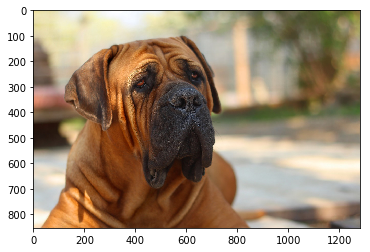

My best guess is that its breed is Mastiff
Here is a picture of a Mastiff:


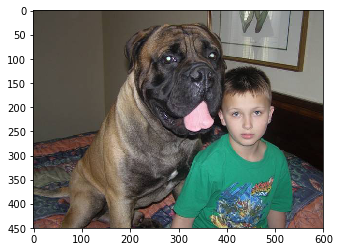

In [126]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
dog_app('Test images/test1.jpg')

Top 3 dog breed prediction probabilities:
             Breed  Probability
61  English_setter     0.000045
77      Great_dane     0.000591
56       Dalmatian     0.999304
A dog is detected.


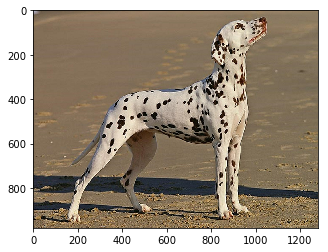

My best guess is that its breed is Dalmatian
Here is a picture of a Dalmatian:


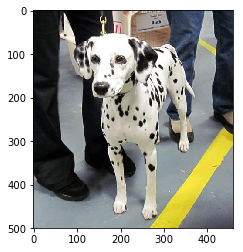

In [127]:
dog_app('Test images/test2.jpg')

In [128]:
dog_app('Test images/test3.png')

I can't seem to identify your picture as either a human or a dog. Please try again with another picture. I can use pictures of either humans or dogs and pictures with clear faces work best


Top 3 dog breed prediction probabilities:
                  Breed  Probability
21     Belgian_tervuren     0.000999
19     Belgian_malinois     0.004375
70  German_shepherd_dog     0.994070
A dog is detected.


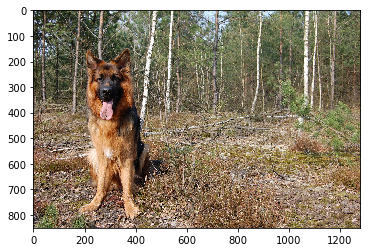

My best guess is that its breed is German shepherd dog
Here is a picture of a German_shepherd_dog:


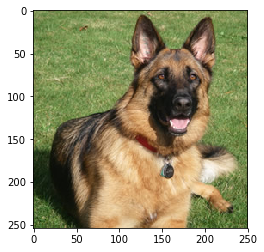

In [129]:
dog_app('Test images/test4.jpg')

Top 3 dog breed prediction probabilities:
                Breed  Probability
66      Finnish_spitz     0.003008
107  Norwegian_buhund     0.003679
3               Akita     0.989777
A dog is detected.


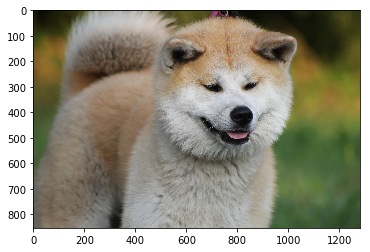

My best guess is that its breed is Akita
Here is a picture of a Akita:


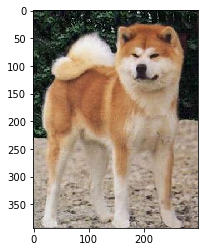

In [130]:
dog_app('Test images/test12.jpg')

In [131]:
dog_app('Test images/test11.jpg')

I can't seem to identify your picture as either a human or a dog. Please try again with another picture. I can use pictures of either humans or dogs and pictures with clear faces work best


Top 3 dog breed prediction probabilities:
              Breed  Probability
69  German_pinscher     0.080761
81         Havanese     0.118172
55        Dachshund     0.129071
A human is detected.


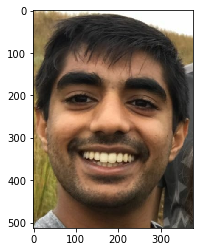

Hello, you look most like the Dachshund
Here is a picture of a Dachshund:


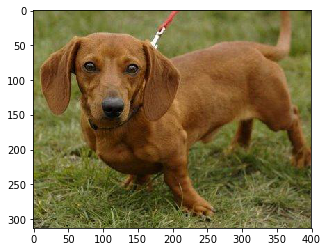

In [132]:
dog_app('Test images/test5.png')

Top 3 dog breed prediction probabilities:
                                  Breed  Probability
132                   Yorkshire_terrier     0.065613
3                                 Akita     0.096460
111  Nova_scotia_duck_tolling_retriever     0.208870
A human is detected.


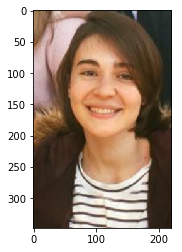

Hello, you look most like the Nova scotia duck tolling retriever
Here is a picture of a Nova_scotia_duck_tolling_retriever:


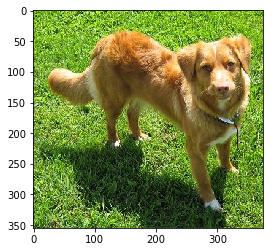

In [133]:
dog_app('Test images/test6.png')

Top 3 dog breed prediction probabilities:
                    Breed  Probability
81               Havanese     0.083524
55              Dachshund     0.091911
74  Glen_of_imaal_terrier     0.099666
A human is detected.


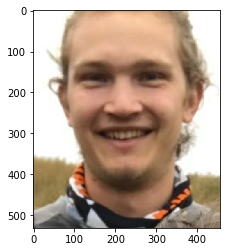

Hello, you look most like the Glen of imaal terrier
Here is a picture of a Glen_of_imaal_terrier:


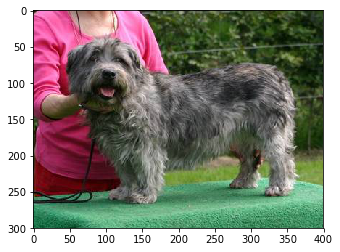

In [134]:
dog_app('Test images/test7.png')

Top 3 dog breed prediction probabilities:
                            Breed  Probability
1                    Afghan_hound     0.051938
45  Cavalier_king_charles_spaniel     0.055203
48                Chinese_crested     0.079523
A human is detected.


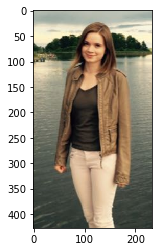

Hello, you look most like the Chinese crested
Here is a picture of a Chinese_crested:


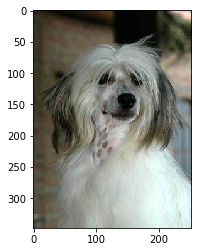

In [135]:
dog_app('Test images/test8.png')

Top 3 dog breed prediction probabilities:
            Breed  Probability
116     Pekingese     0.051469
23   Bichon_frise     0.067465
3           Akita     0.166728
A human is detected.


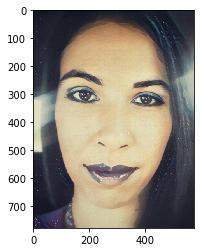

Hello, you look most like the Akita
Here is a picture of a Akita:


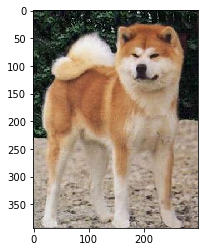

In [136]:
dog_app('Test images/test9.png')

Top 3 dog breed prediction probabilities:
                  Breed  Probability
83   Icelandic_sheepdog     0.107852
107    Norwegian_buhund     0.110750
81             Havanese     0.114206
A human is detected.


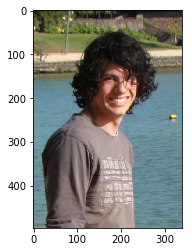

Hello, you look most like the Havanese
Here is a picture of a Havanese:


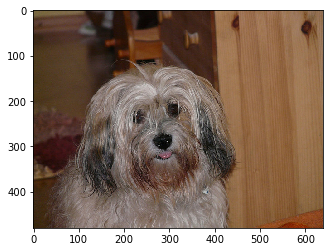

In [137]:
dog_app('Test images/test10.png')